In [11]:
import pandas as pd
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
con = sqlite3.connect("app.db")
df = pd.read_sql_query("SELECT * from report_histo", con)
excel = pd.read_excel("Dossier_Patient_clean_myocapt_KC_v6.xlsx")

In [12]:
def table_to_df(df):
    # Transformation de la table SQLite en dataframe en parsant l'arbre JSON
    # Return un dictionnaire et une liste de colonnes (les features histo)
    tree_as_dict = {}
    features_col = []
    for index, row in df.iterrows():
        tree_as_dict.setdefault("id", []).append(row[0])
        tree_as_dict.setdefault("patient_id", []).append(row[1])
        tree_as_dict.setdefault("expert_id", []).append(row[2])
        tree_as_dict.setdefault("biopsie_id", []).append(row[3])
        tree_as_dict.setdefault("muscle_prelev", []).append(row[4])
        tree_as_dict.setdefault("age_biopsie", []).append(row[5])
        tree_as_dict.setdefault("date_envoie", []).append(row[6])
        tree_as_dict.setdefault("gene_diag", []).append(row[7])
        tree_as_dict.setdefault("comment", []).append(row[9])
        tree_as_dict.setdefault("conclusion", []).append(row[10])
        tree_as_dict.setdefault("datetime", []).append(row[11])

        my_tree = json.loads(row[8])
        for feature in my_tree:
            tree_as_dict.setdefault(feature["text"], []).append(float(feature["data"].get("presence", -0.25)))
            if index==0:
                features_col.append(feature["text"])
    return tree_as_dict, features_col
tree_as_dict, features_col = table_to_df(df)
df2 = pd.DataFrame.from_dict(tree_as_dict)

# Simplifier le diagnostic en regroupant les sous-type sous 5 catégories: Némaline, Core Myo, CentroNuc ou UNCLEAR ou OTHER
df2 = df2.replace({"COM_CCD":"COM", "COM_MMM":"COM", "NM_CAP":"NM", "CFTD":"OTHER", "NON_CM":"OTHER","CM":"UNCLEAR"})
# Simplification de l'encodage:
# No Info (-0.25) -> 0. 
# Absence reste 0
# Et Présence faible/modéré/forte (0.25 0.5 0.75) -> 1
df2 = df2.replace({-0.25:0, 0.25:1, 0.5:1, 0.75:1})


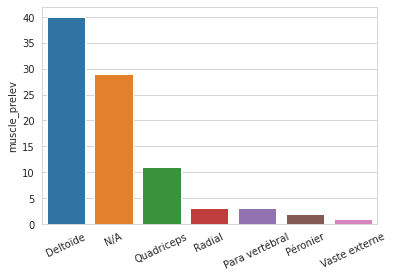

In [13]:
muscle_prelev = df2["muscle_prelev"].value_counts()
# Empty index to N/A
as_list = muscle_prelev.index.tolist()
idx = as_list.index('')
as_list[idx] = 'N/A'
muscle_prelev.index = as_list
sns.barplot(x=muscle_prelev.index, y=muscle_prelev)
var = plt.xticks(rotation=25)

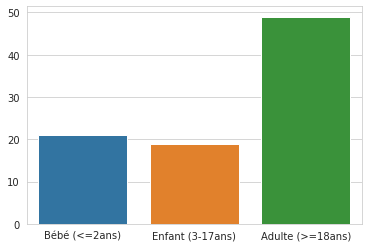

In [14]:
age_biopsie = df2["age_biopsie"].value_counts()
bebe = age_biopsie.where(age_biopsie.index<=2).sum()
enfant = age_biopsie.where((age_biopsie.index>2) & (age_biopsie.index<18)).sum()
adulte = age_biopsie.where(age_biopsie.index>=18).sum()
g = sns.barplot(x=["Bébé (<=2ans)", "Enfant (3-17ans)", "Adulte (>=18ans)"], y=[bebe, enfant, adulte])

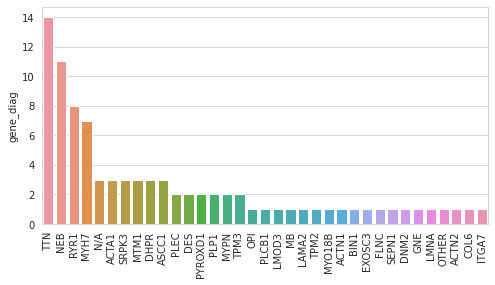

In [15]:
gene_diag = df2["gene_diag"].value_counts()
fig_dims = (8, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=gene_diag.index, y=gene_diag, ax=ax)
var = plt.xticks(rotation=90)

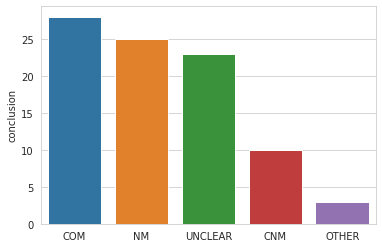

In [16]:
# Merge sub types for stats
conclusion = df2["conclusion"].value_counts()
g = sns.barplot(x=conclusion.index, y=conclusion)

In [17]:
# Les features les plus présent chez les NM
df2.where(df2["conclusion"]=="NM")[features_col].sum().sort_values(ascending=False)[0:10]

Matériel Fuscinophile: Amas/Aggrégat sombre             22.0
Taille Inégale                                          22.0
Bâtonnets - Rods                                        20.0
Prédominance Fibre Type 1                               18.0
Type 1 Atrophiées (petites)                             15.0
Désorganisation structurelle                            12.0
Type 2 Atrophiées (petites)                             10.0
Noyaux Centralisé                                        8.0
Activité ATPasique Anormale Localement (Zone Claire)     7.0
Uniformité de Type                                       7.0
dtype: float64

In [18]:
# Les features les plus présent chez les cores myo
df2.where(df2["conclusion"]=="COM")[features_col].sum().sort_values(ascending=False)[0:10]

Taille Inégale                                          28.0
Prédominance Fibre Type 1                               26.0
Noyaux Centralisé                                       14.0
Désorganisation structurelle                            14.0
Sans Topographie                                        14.0
Activité Oxy: Zone Claire (pâle)                        11.0
Core Périphériques                                      10.0
Type 2 Hypertrophiques (grandes)                        10.0
Activité ATPasique Anormale Localement (Zone Claire)     9.0
Activité Oxy: Alvéole Core-like                          9.0
dtype: float64

In [19]:
# Les features les plus présent chez les Centro nuclear myo
df2.where(df2["conclusion"]=="CNM")[features_col].sum().sort_values(ascending=False)[0:10]

Noyaux Centralisé                       9.0
Taille Inégale                          8.0
Prédominance Fibre Type 1               7.0
Désorganisation structurelle            4.0
HETG: Bord arrondis                     3.0
Type 1 Atrophiées (petites)             3.0
Uniformité de Type                      2.0
Necklace Fibers                         2.0
Augmentation du Collagène Endosymial    2.0
Noyaux Internalisé                      2.0
dtype: float64

In [20]:
# Pour le learning futur: sortir la matrice de 0/1 en .csv
# df2.to_csv("histo_feature.csv", index=False)